# LSM Approach

## Reproducing "A Numerical Example" of LSM Paper
Link to the paper: (Longstaff & Schwartz, 2001)[https://people.math.ethz.ch/~hjfurrer/teaching/LongstaffSchwartzAmericanOptionsLeastSquareMonteCarlo.pdf]

### Building the table of Stock price paths

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm

In [2]:
# We generate the prices in eight paths, according to the table of LSM paper
# eight paths
path_1 = np.array([1.00, 1.09, 1.08, 1.34])
path_2 = np.array([1.00, 1.16, 1.26, 1.54])
path_3 = np.array([1.00, 1.22, 1.07, 1.03])
path_4 = np.array([1.00, 0.93, 0.97, 0.92])
path_5 = np.array([1.00, 1.11, 1.56, 1.52])
path_6 = np.array([1.00, 0.76, 0.77, 0.90])
path_7 = np.array([1.00, 0.92, 0.84, 1.01])
path_8 = np.array([1.00, 0.88, 1.22, 1.34])

In [3]:
price_paths = np.array([path_1, path_2, path_3, path_4, 
            path_5, path_6, path_7,path_8])
price_paths

array([[1.  , 1.09, 1.08, 1.34],
       [1.  , 1.16, 1.26, 1.54],
       [1.  , 1.22, 1.07, 1.03],
       [1.  , 0.93, 0.97, 0.92],
       [1.  , 1.11, 1.56, 1.52],
       [1.  , 0.76, 0.77, 0.9 ],
       [1.  , 0.92, 0.84, 1.01],
       [1.  , 0.88, 1.22, 1.34]])

In [4]:
# To show the table in more similar format to the Paper, we convert it to Dataframe

S = pd.DataFrame(data=price_paths,
                index=np.arange(1,8+1), 
                columns=["t=0","t=1", "t=2", "t=3"])

S.index.name = "Path"

S

,t=0,t=1,t=2,t=3
Path,,,,
1,1.0,1.09,1.08,1.34
2,1.0,1.16,1.26,1.54
3,1.0,1.22,1.07,1.03
4,1.0,0.93,0.97,0.92
5,1.0,1.11,1.56,1.52
6,1.0,0.76,0.77,0.90
7,1.0,0.92,0.84,1.01
8,1.0,0.88,1.22,1.34


In [5]:
# Strike Price
K = 1.10                                  

# immediate reward from exercising the Put option at t
exercise_payoff = np.maximum(K - S, 0)             
exercise_payoff

,t=0,t=1,t=2,t=3
Path,,,,
1,0.1,0.01,0.02,0.00
2,0.1,0.00,0.00,0.00
3,0.1,0.00,0.03,0.07
4,0.1,0.17,0.13,0.18
5,0.1,0.00,0.00,0.00
6,0.1,0.34,0.33,0.20
7,0.1,0.18,0.26,0.09
8,0.1,0.22,0.00,0.00


### Cash- flow matrix at time 3

- We are planning to reproduce the following cash flow matrix

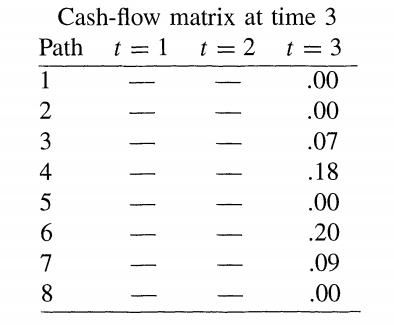

In [6]:
# cf is the short version for Cash-flow matrix

cf = exercise_payoff.copy()
cf[:] = 0
cf.loc[:,"t=3"] = exercise_payoff.loc[:, "t=3"]
cf

,t=0,t=1,t=2,t=3
Path,,,,
1,0.0,0.0,0.0,0.00
2,0.0,0.0,0.0,0.00
3,0.0,0.0,0.0,0.07
4,0.0,0.0,0.0,0.18
5,0.0,0.0,0.0,0.00
6,0.0,0.0,0.0,0.20
7,0.0,0.0,0.0,0.09
8,0.0,0.0,0.0,0.00


### Regression at Time t=2

In [7]:
# dicount factor based on 6% riskless rate
df = np.exp(-0.06 * 1)          

# This is a table for all the path
table_t_2 = pd.DataFrame({"Y":cf["t=3"]*df, "X":S["t=2"]})   


- We need the in-money paths: In the Money Paths:

In [8]:
id_money_t_2 = S[S.iloc[:, 2] < K].index
table_t_2_inmoney=table_t_2.loc[id_money_t_2]
table_t_2_inmoney

,Y,X
Path,,
1,0.000000,1.08
3,0.065924,1.07
4,0.169518,0.97
6,0.188353,0.77
7,0.084759,0.84


- Regression of the X and Y at time 2 

In [9]:
rg_t_2 = np.polyfit(table_t_2_inmoney["X"], table_t_2_inmoney["Y"], 2)

print("The Conditional Expectaion function is %.3f + %.3fX %.3fX^2" % 
                                (rg_t_2[2], rg_t_2[1], rg_t_2[0]))

The Conditional Expectaion function is -1.070 + 2.983X -1.814X^2


### Optimal early exercise decision at time 2

In [10]:
# Here we use our regression model to predict continutaion value at time t=2 (c_t_2)
C_t_2 = np.polyval(rg_t_2, S.loc[id_money_t_2,"t=2"])

# The Exercise payoff is "K- S.loc[id_money_t_2, "t=2"]" while Continutaion C_2_t
Opt_dec_org = pd.DataFrame(data={"Exercise":exercise_payoff.loc[id_money_t_2, "t=2"],
                            "Continution":C_t_2})

Opt_dec = Opt_dec_org.round(4) 
Opt_dec


,Exercise,Continution
Path,,
1,0.02,0.0367
3,0.03,0.0459
4,0.13,0.1175
6,0.33,0.1520
7,0.26,0.1564


### Cash flow matrix at time=2 

- We are planning to reproduce the following cash flow matrix:

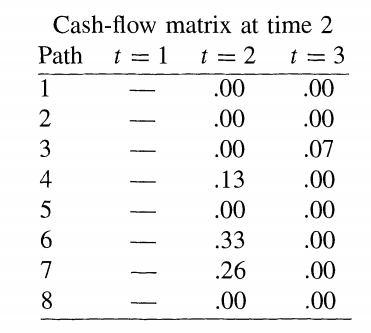

In [11]:
# Here is the decision point, if continuation if bigger than exercise payoff, we exercise, 
# otherwise continue
cf.loc[id_money_t_2,"t=2"] = np.where(exercise_payoff.loc[id_money_t_2,"t=2"] > C_t_2, 
    exercise_payoff.loc[id_money_t_2,"t=2"], 0)

# When at any time t>>t+1, we execise, cashflow in rest of steps is equal to zero
cf.loc[id_money_t_2,"t=3"] = np.where(cf.loc[id_money_t_2,"t=2"] > 0, 
    0, cf.loc[id_money_t_2,"t=3"])
cf

,t=0,t=1,t=2,t=3
Path,,,,
1,0.0,0.0,0.00,0.00
2,0.0,0.0,0.00,0.00
3,0.0,0.0,0.00,0.07
4,0.0,0.0,0.13,0.00
5,0.0,0.0,0.00,0.00
6,0.0,0.0,0.33,0.00
7,0.0,0.0,0.26,0.00
8,0.0,0.0,0.00,0.00


### Regression at Time t=1

In [12]:
table_t_1 = pd.DataFrame({"Y":cf["t=2"]*df, "X":S["t=1"]})   # This is a table for all the path
id_money_t_1 = S[S.iloc[:, 1] < K].index
table_t_1_inmoney=table_t_1.loc[id_money_t_1]
table_t_1_inmoney

,Y,X
Path,,
1,0.000000,1.09
4,0.122429,0.93
6,0.310782,0.76
7,0.244859,0.92
8,0.000000,0.88


In [13]:
rg_t_1 = np.polyfit(table_t_1_inmoney["X"], table_t_1_inmoney["Y"], 2)

print("The Conditional Expectaion function is %.3f  %.3fX %.3fX^2" % 
                                (rg_t_1[2], rg_t_1[1], rg_t_1[0]))

The Conditional Expectaion function is 2.038  -3.335X 1.356X^2


In [14]:
C_t_1 = np.polyval(rg_t_1.round(3), S.loc[id_money_t_1].iloc[:,1])

Opt_dec_org_t_1 = pd.DataFrame(data={"Exercise":exercise_payoff.loc[id_money_t_1, "t=1"],
                            "Continution":C_t_1})
Opt_dec_t_1 = Opt_dec_org_t_1.round(4) 
Opt_dec_t_1

,Exercise,Continution
Path,,
1,0.01,0.0139
4,0.17,0.1093
6,0.34,0.2866
7,0.18,0.1175
8,0.22,0.1533


### Cash flow matrix at time=1 

- We are planning to reproduce the following cash flow matrix:

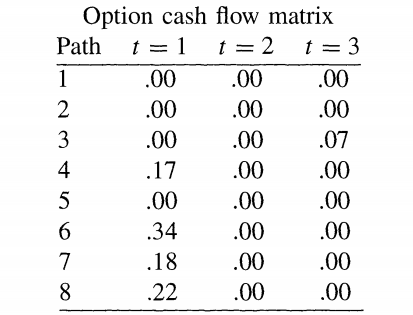

In [15]:
cf.loc[id_money_t_1,"t=1"] = np.where(exercise_payoff.loc[id_money_t_1,"t=1"] > C_t_1, 
    exercise_payoff.loc[id_money_t_1,"t=1"], 0)
    
cf.loc[id_money_t_2,"t=2"] = np.where(cf.loc[id_money_t_1,"t=1"] > 0, 
    0, cf.loc[id_money_t_1,"t=2"])
cf

,t=0,t=1,t=2,t=3
Path,,,,
1,0.0,0.00,0.0,0.00
2,0.0,0.00,0.0,0.00
3,0.0,0.00,0.0,0.07
4,0.0,0.17,0.0,0.00
5,0.0,0.00,0.0,0.00
6,0.0,0.34,0.0,0.00
7,0.0,0.18,0.0,0.00
8,0.0,0.22,0.0,0.00


- Dicount the time and average of all the paths to arrive value of option at time=0 

In [16]:
DCF_all_paths = cf["t=1"]*df + cf["t=2"]*df**2 + cf["t=3"]*df**3

Option_Value = sum(DCF_all_paths)/8

print("The value of American Put Option is: %.4f" % (Option_Value))

The value of American Put Option is: 0.1144


## Main Big loop:

In [17]:
def Val_Ame_Put_Opt(S, K, Nsteps, paths, r, T):

    dt = T/Nsteps
    df = np.exp(-r * dt)   
    
    exercise_payoff = np.maximum(K - S, 0)             
    
    cf = exercise_payoff.copy()
    cf[:] = 0
    cf.iloc[:,Nsteps] = exercise_payoff.iloc[:, Nsteps]
    

    for t in range(Nsteps-1,0,-1):

        table_t = pd.DataFrame({"Y":cf.iloc[:,t+1]*df, "X":S.iloc[:,t]})
        id_money_t = S[S.iloc[:, t] < K].index
        
        table_t_inmoney=table_t.loc[id_money_t]

    
        rg_t = np.polyfit(table_t_inmoney["X"], table_t_inmoney["Y"], 2)
   
        C_t = np.polyval(rg_t, S.loc[id_money_t].iloc[:,t])
    

        cf.loc[id_money_t,t] = np.where(exercise_payoff.loc[id_money_t,t] > C_t, 
            exercise_payoff.loc[id_money_t,t], 0)

        for tt in range(t, Nsteps):
            
            cf.loc[id_money_t,tt+1] = np.where(cf.loc[id_money_t,t] > 0, 
                0, cf.loc[id_money_t,tt+1])

    Sum_DCF = 0

    for t in range(Nsteps,0,-1):
    
        Sum_DCF = sum(cf.loc[:,t])*np.exp(-dt*r*t) + Sum_DCF

    Option_Value = Sum_DCF/paths

    # return both cashflow and the price of the option
    return cf, Option_Value

    

### Applying the the above function to the Example

In [18]:
S_Example = pd.DataFrame(data=price_paths,
                index=np.arange(1,8+1))

In [19]:
S_Example

,0,1,2,3
1,1.0,1.09,1.08,1.34
2,1.0,1.16,1.26,1.54
3,1.0,1.22,1.07,1.03
4,1.0,0.93,0.97,0.92
5,1.0,1.11,1.56,1.52
6,1.0,0.76,0.77,0.90
7,1.0,0.92,0.84,1.01
8,1.0,0.88,1.22,1.34


In [20]:
# Price Paths
S = S_Example

# Strike Price
K_val = 1.1

# Number of exercise times until end of horiozon
Nsteps_val = 3

# Number of path
paths_val = 8

# Riskless Free rate
r_val = 0.06

# End of the Horizon
T_val = 3

In [21]:
CF_example,Value_Example = Val_Ame_Put_Opt(S=S_Example, K=K_val,Nsteps=Nsteps_val, 
                                           paths=paths_val, r=r_val, T=T_val)

In [22]:
print("The Cash Flow matrix resulting from LSM method")
CF_example

The Cash Flow matrix resulting from LSM method


,0,1,2,3
1,0.0,0.00,0.0,0.00
2,0.0,0.00,0.0,0.00
3,0.0,0.00,0.0,0.07
4,0.0,0.17,0.0,0.00
5,0.0,0.00,0.0,0.00
6,0.0,0.34,0.0,0.00
7,0.0,0.18,0.0,0.00
8,0.0,0.22,0.0,0.00


In [23]:
print("The Value of American Put Option is:  %.4f" % Value_Example)

The Value of American Put Option is:  0.1144


### Geometric Brownian Motion Price Model

In [24]:
def SimulateGBM(S0, r, vol, T, paths, Nsteps, reduce_variance = True):
    
    Nsteps = int(Nsteps)
    dt = T/Nsteps
    
    Z = np.random.normal(0, 1, paths//2 * Nsteps).reshape((paths//2, Nsteps))
    
    if reduce_variance:
      Z_inv = -Z
    else:
      Z_inv = np.random.normal(0, 1, paths//2 * Nsteps).reshape((paths//2, Nsteps))
    
    dWt = np.sqrt(dt) * Z
    dWt_inv = np.sqrt(dt) * Z_inv
    dWt = np.concatenate((dWt, dWt_inv), axis=0)
    
    St = np.zeros((paths, Nsteps + 1))
    St[:, 0] = S0
    
    for i in range (1, Nsteps + 1):
        St[:, i] = St[:, i - 1]*np.exp((r - 1/2*np.power(vol, 2))*dt + vol*dWt[:, i - 1])
    
    St = pd.DataFrame(data=St,
                index=np.arange(1,paths+1))
    
    return St


In [25]:
S0_val = 36
r_val = 0.06
vol_val = 0.2
T_val = 1
paths_val = 1000
Nsteps_val = 50

In [26]:
GBM_price = SimulateGBM(S0=S0_val,r=r_val, vol=vol_val, T=T_val,paths=paths_val, 
            Nsteps=Nsteps_val, reduce_variance=True)

In [27]:
# Strike Price
K_val = 40

In [29]:
CF_GBM,Value_GBM = Val_Ame_Put_Opt(S=GBM_price, K=K_val,Nsteps=Nsteps_val, 
                                           paths=paths_val, r=r_val, T=T_val)
Value_Example

3.9459731073722777

In [ ]:
def power_polynomials(S, k):
    
    #  the first k terms of Laguerre Polynomials (k<=4)
    x1 = np.ones(S.shape)
    x2 = S
    x3 = S**2
    x4 = S**3 
    
    X  = [np.stack([x1, x2], axis = 1),
          np.stack([x1, x2, x3], axis = 1),
          np.stack([x1, x2, x3, x4], axis = 1)]
    
    return X[k-2]

## Binomial Tree -

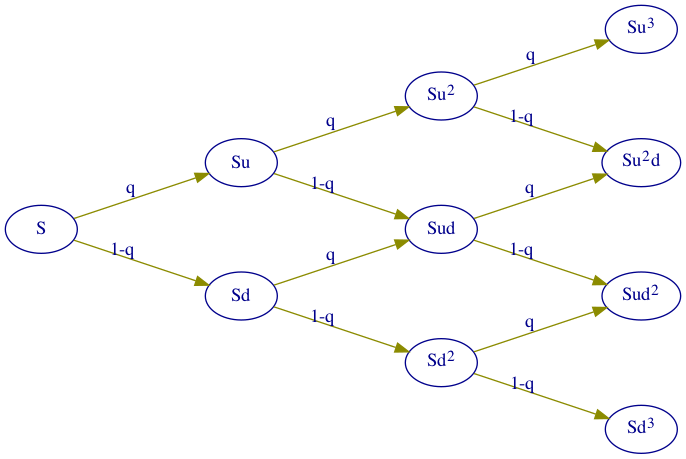

$$qu+\frac{1-q}{u}=e^{\frac{rT}{n}} \Rightarrow q= \frac{u.e^{\frac{rT}{n}}-1}{u^2-1}=\frac{e^{\frac{rT}{n}}-d}{u-d}$$

### Case: Put Option

In [30]:
def binomial_put(S, K, T, r, vol, N):
    
    # Number of time steps
    dt = T/N
    
    # u value 
    u =  np.exp(vol * np.sqrt(dt))
    
    # 1/u value
    d = 1/u
    
    # 
    q = (np.exp(r * dt) - d)/(u - d)
    
    # probability of q
    
    # 
    C = {}
    
    #payoff function for put options    
    for m in range(0, N+1):
        C[(N, m)] = max(K - S * (u ** (2*m - N)), 0) 
    
    
    for k in range(N-1, -1, -1):

        for m in range(0,k+1):

            future_value = np.exp(-r * dt) * (q * C[(k+1, m+1)] + (1-q) * C[(k+1, m)])
            exercise_value =  max(K - S * (u ** (2*m-k)),0)
            C[(k, m)] = max(future_value, exercise_value)
    
    return C[(0,0)], C

In [31]:

S_val = 36
K_val = 40
T_val = 1
N_val = 10
vol_val = 0.2
r_val = 0.06

In [32]:
C0, C = binomial_put(S=S_val, K=K_val, T=T_val, r=r_val, vol=vol_val, N=N_val)
print(f"The Price of American Put Option is = {C0:.3f}")

The Price of American Put Option is = 4.470


### Show Lattice in Data Farme Format

In [33]:
def C_to_DF_binomial(C, N):

    DF_binomial = pd.DataFrame(index=range(N), columns=range(N))
    
    for key, val in C.items():
        DF_binomial.loc[key[1], key[0]] = val
    
    return DF_binomial 

In [34]:
C_to_DF_binomial(C, N=N_val)

,0,1,2,3,4,5,6,7,8,9,10
0,4.470402,6.206334,8.277448,10.22163,12.046659,13.759837,15.368019,16.877641,18.294742,19.624994,20.873718
1,NaN,2.992296,4.378919,6.206334,8.277448,10.22163,12.046659,13.759837,15.368019,16.877641,18.294742
2,NaN,NaN,1.805071,2.819216,4.262419,6.206334,8.277448,10.22163,12.046659,13.759837,15.368019
3,NaN,NaN,NaN,0.932422,1.580206,2.598805,4.114999,6.206334,8.277448,10.22163,12.046659
4,NaN,NaN,NaN,NaN,0.372521,0.70109,1.293024,2.319894,4.0,6.206334,8.277448
5,NaN,NaN,NaN,NaN,NaN,0.087392,0.187754,0.403373,0.866612,1.86184,4.000000
6,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.000000
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.000000
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000


### Case: Call Option

The Call option code is almost same the Put option, but this time we chnage the **Exercise Value**:
to :

$$max(Su^{2m-k}-K,0)$$

In [35]:
def binomial_call(S, K, T, r, vol, N):
    
    # Number of time steps
    dt = T/N
    
    # u value 
    u =  np.exp(vol * np.sqrt(dt))
    
    # 1/u value
    d = 1/u
    
    # 
    q = (np.exp(r * dt) - d)/(u - d)
    
    # probability of q
    
    # 
    C = {}

    # Payoff in End node
    for m in range(0, N+1):
        C[(N, m)] = max(S * (u ** (2*m - N))-K, 0) #New payoff function for put options
    
    for k in range(N-1, -1, -1):

        for m in range(0,k+1):

            future_value = np.exp(-r * dt) * (q * C[(k+1, m+1)] + (1-q) * C[(k+1, m)])
            exercise_value =  max(S * (u ** (2*m-k))-K,0)
            C[(k, m)] = max(future_value, exercise_value)
    
    return C[(0,0)], C

In [36]:
# Spot Price
S_val = 36
# Strike Price
K_val = 40
# Time Period
T_val = 1
# risk-free rate
r_val = 0.06
# volatility rate
vol_val = 0.2
# Number of steps
N_val = 100

In [37]:
C0, C = binomial_call(S=S_val,K=K_val, T=T_val, r=r_val, vol=vol_val, N=N_val)

In [38]:
print(f"The Price of American Call Option is = {C0:.3f}")

The Price of American Call Option is = 2.178


In [39]:
def european_price(S, K, T, r, vol ,is_call: bool):
    
    sigma_sqrt: float = vol * np.sqrt(T)
    
    d1 = (np.log(S / K) +
                     (r + vol ** 2 / 2.) * T) / sigma_sqrt
    d2 = d1 - sigma_sqrt
    
    if is_call:
            ret = S * norm.cdf(d1) - \
                K * np.exp(-r * T) * norm.cdf(d2)
    else:
            ret = K * np.exp(-r * T) * norm.cdf(-d2) - \
                S * norm.cdf(-d1)
    return ret

In [40]:
european_price(S=S_val, K=K_val, T=T_val, r=r_val, vol=vol_val,is_call=True)
print(f"The Price of European Call Option is = {C0:.3f}")

The Price of European Call Option is = 2.178
